# **CONFIGURAÇÕES INICIAIS**

In [3]:
# @title **Importando Bibliotecas**

# Para manipulação e análise de dados em tabelas (dataframes)
import pandas as pd
pd.set_option("display.precision", 2)

# Para cálculos númericos rápidos e eficientes com vetores e matrizes
import numpy as np

# Para criar gráficos e visualizações estáticas
import matplotlib.pyplot as plt

# Para visualização de dados estatísticas com gráficos mais bonitos e informativos
import seaborn as sns

# Para análises de probabilidade
from scipy.stats import binom, poisson, norm, zscore

# Para baixar o CSV via link do Drive
import gdown

### **Importando o CSV via Link do Drive**

In [4]:
# ID do arquivo no Google Drive
file_id = '19YSu2-PNFRcwnr8l2Rf8ReyrCWI2egC-'

# Montar a URL de download direto
url = f'https://drive.google.com/uc?id={file_id}'

# Nome do arquivo a ser salvo localmente
output = 'Mortalidade_Geral_2021.csv'

# Fazer o download
gdown.download(url, output, quiet=False)

# Carregar o CSV
df = pd.read_csv(output, sep=';')

# Impedir importação manual
executar_proxima_celula = False

Downloading...
From (original): https://drive.google.com/uc?id=19YSu2-PNFRcwnr8l2Rf8ReyrCWI2egC-
From (redirected): https://drive.google.com/uc?id=19YSu2-PNFRcwnr8l2Rf8ReyrCWI2egC-&confirm=t&uuid=b8559e59-d99a-4bea-b778-ec6e7d198b7d
To: /content/Mortalidade_Geral_2021.csv
100%|██████████| 633M/633M [00:05<00:00, 114MB/s]
/tmp/ipython-input-4-1181111901.py:16: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output, sep=';')


In [5]:
#@title **Carregando o CSV sem Importar Novamente**

# Nome do arquivo a ser salvo localmente
output = 'Mortalidade_Geral_2021.csv'

# Carregar o CSV
df = pd.read_csv(output, sep=';')

/tmp/ipython-input-5-2916767292.py:7: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output, sep=';')


### **Importando o CSV Manualmente (caso o método anterior não funcione)**

Caso o método anterior não funcione, realize o upload manual do CSV:

*   Baixe o arquivo do dataset [aqui](https://opendatasus.saude.gov.br/dataset/sim/resource/2dee2fc9-d19f-41bc-b058-6d4154f126ab).
*   Crie uma pasta "Colab Notebooks" no Drive e faça o upload do CSV nela.

In [ ]:
#@title { vertical-output: true, form-width: "40%" }
from google.colab import drive

if not executar_proxima_celula:
  print("Esta célula não foi executada pois a célula anterior já baixou o CSV.")
else:
  drive.mount('/content/drive/', force_remount=True)
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mortalidade_Geral_2021.csv', sep=';')

### **Preparação dos Dados**


In [8]:
# Filtrando somente as colunas a serem analisadas
colunas_desejadas = [
    'DTOBITO',      # Data do óbito
    'IDADE',        # Idade em formato codificado
    'SEXO',         # 1 = masculino, 2 = feminino
    'RACACOR',      # Raça/Cor
    'OCUP',         # Ocupação
    'LOCOCOR',      # Local de ocorrência do óbito
    'ASSISTMED',    # Assistência médica
    'CAUSABAS',     # Causa básica da morte (CID-10)
    'TPOBITOCOR',   # Tipo de local do óbito
    'NECROPSIA'     # Execução ou não de necropsia
]

sim = df[colunas_desejadas]

# Filtrando registros em que idade ≥ 1
sim = sim[sim['IDADE'].astype(str).str.startswith('4')]

# Retirando uma amostra do dataset
sim = sim.sample(n=100000, random_state=42)

# Decodificando variáveis categóricas
sim['SEXO_DESC'] = sim['SEXO'].map({1: 'Masculino', 2: 'Feminino'})
sim['SEXO_DESC'] = sim['SEXO_DESC'].fillna('Ignorado')

sim['ASSISTMED_DESC'] = sim['ASSISTMED'].map({
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
})

sim['LOCOCOR_DESC'] = sim['LOCOCOR'].map({
    1: 'Hospital',
    2: 'Outro estabelecimento de saúde',
    3: 'Domicílio',
    4: 'Via pública',
    5: 'Outros',
    9: 'Ignorado'
})

sim['NECROPSIA_DESC'] = sim['NECROPSIA'].map({
    1: 'Realizada',
    2: 'Não realizada',
    9: 'Ignorado'
})

# Transformando a idade
def converter_idade(codigo):
    codigo = str(int(codigo)).zfill(3)
    valor = int(codigo[1:])
    return valor

sim['IDADE_ANOS'] = sim['IDADE'].apply(converter_idade)

sim.head()

,DTOBITO,IDADE,SEXO,RACACOR,OCUP,LOCOCOR,ASSISTMED,CAUSABAS,TPOBITOCOR,NECROPSIA,SEXO_DESC,ASSISTMED_DESC,LOCOCOR_DESC,NECROPSIA_DESC,IDADE_ANOS
225649,5092021,466,1,4.0,715505.0,1,1.0,R99,NaN,2.0,Masculino,Sim,Hospital,Não realizada,66
280731,20042021,443,2,4.0,999992.0,3,2.0,X959,9.0,1.0,Feminino,Não,Domicílio,Realizada,43
1515340,25042021,471,2,NaN,NaN,1,1.0,I509,NaN,2.0,Feminino,Sim,Hospital,Não realizada,71
1156536,24022021,473,1,1.0,999993.0,1,NaN,D599,NaN,NaN,Masculino,NaN,Hospital,NaN,73
1181779,11022021,454,1,2.0,NaN,1,9.0,B342,NaN,9.0,Masculino,Ignorado,Hospital,Ignorado,54


# **SIM - ANÁLISES DE PROBABILIDADES**

In [9]:
# @title { vertical-output: true, form-width: "50%" }
# VALORES GERAIS DE INTERESSE

# Tamanho amostral
n_amostral = len(sim)
print(f'Tamanho da Amostra: {n_amostral}')

Tamanho da Amostra: 100000


## **1. Probabilidade Composta (União ou Interseção)**

### **1.1 Qual a probabilidade de óbito ser de uma mulher e causado por neoplasia maligna?**

**Objetivo:** calcular 𝑃(𝐹 ∩ neoplasia)


In [10]:
# Regex para capturar códigos entre C00 e C97 com opcional 4º caractere alfanumérico
regex_neoplasia = r'^C(0[0-9]|[1-8][0-9]|9[0-7])[A-Z0-9]?$'

# Filtrando causas básicas que são neoplasias malignas
filtro_neoplasia = sim['CAUSABAS'].astype(str).str.match(regex_neoplasia)

# Filtra mulheres (assumindo '2' = feminino)
filtro_mulher = sim['SEXO'] == 2

# Combina filtros: mulher e causa neoplasia
interseccao = sim[(filtro_neoplasia) & (filtro_mulher)]

# Calcula a probabilidade conjunta P(F ∩ neoplasia)
p_mulher_neoplasia = len(interseccao) / n_amostral

print(f"P(F ∩ neoplasia) = {p_mulher_neoplasia:.4f} → {p_mulher_neoplasia:.2%}")

P(F ∩ neoplasia) = 0.0612 → 6.12%


## **2. Probabilidade Condicional**

### **2.1 Probabilidade de óbito por causas violentas dado que a pessoa era jovem (15–29 anos)**

**Objetivo:** calcular 𝑃 ( causa violenta ∣ idade 15–29 )

In [11]:
# CRIAÇÃO DE FUNÇÕES AUXILIARES

import re

# Coletar somente os CIDs válidos para causa violenta
def causa_violenta(cid):
    if isinstance(cid, str):
        match = re.match(r'^([A-Z])(\d{2})', cid)
        if match:
            letra = match.group(1)
            numero = int(match.group(2))
            if letra == 'V':
                return True
            if letra == 'W':
                return True
            if letra == 'X':
                return True
            if letra == 'Y' and 10 <= numero <= 36:
                return True
    return False

In [28]:
# Filtrando jovens entre 15 e 29 anos
filtro_jovens = sim['IDADE_ANOS'].between(15, 29)
p_jovens = filtro_jovens.mean()

# Filtrando causas básicas que são violentas
filtro_violenta = sim['CAUSABAS'].apply(causa_violenta)

# Combinando filtros: jovens e causa violenta
interseccao = sim[(filtro_jovens) & (filtro_violenta)]
p_interseccao = len(interseccao) / n_amostral

# Calculando a probabilidade condicional
p_violenta_dado_jovem = p_interseccao / p_jovens
print(f"P(Causa Violenta | Idade 15–29 anos) = {p_violenta_dado_jovem:.2%}")

P(Causa Violenta | Idade 15–29 anos) = 58.62%


## **3. Teorema de Bayes**

### **3.1 Probabilidade de um óbito ter ocorrido no domicílio dado que não houve assistência médica**

**Objetivo:** calcular 𝑃 (óbito no domicílio | sem assistência médica)

In [27]:
# Calculando P(A)
p_domicilio = (sim['LOCOCOR'] == 3).mean()

# Calculando P(B)
p_sem_assistencia = (sim['ASSISTMED'] == 2).mean()

# Filtrando óbitos em domicílio
filtro_domicilio = sim['LOCOCOR'] == 3

# Dado que morreu no domicílio, qual a proporção sem assistência?
p_sem_dado_domicilio = (sim[filtro_domicilio]['ASSISTMED'] == 2).mean()

# Calculando
p_domicilio_dado_sem = (p_sem_dado_domicilio * p_domicilio) / p_sem_assistencia
print(f"P(Domicílio | Sem assistência médica) = {p_domicilio_dado_sem:.2%}")

P(Domicílio | Sem assistência médica) = 55.66%


## **4. Distribuições Discretas**

### **4.1 Distribuição Binomial**

Em uma amostra de 10 certidões aleatórias, qual a probabilidade de exatamente 4 terem causa “cardiovascular”?

P(Causa cardiovascular) na amostra = 0.2127 → 21.27%
P(X = 4) com p estimado = 0.1023 → 10.23%


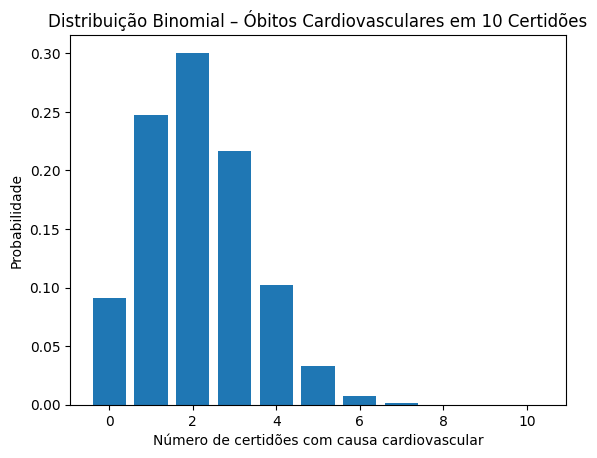

In [14]:
# Verificando se o código CAUSABAS começa com "I"
filtro_cardiovascular = sim['CAUSABAS'].astype(str).str.startswith('I')

# Calculando a proporção na amostra
p_cardiovascular = filtro_cardiovascular.mean()

print(f"P(Causa cardiovascular) na amostra = {p_cardiovascular:.4f} → {p_cardiovascular:.2%}")

# Parâmetros da distribuição binomial
n = 10
k = 4
p = p_cardiovascular  # estimado do dataset

# Distribuição Binomial
prob = binom.pmf(k, n, p)
print(f"P(X = 4) com p estimado = {prob:.4f} → {prob:.2%}")

# Gerando o gráfico
x = range(0, 11)
y = binom.pmf(x, n=10, p=p_cardiovascular)

plt.bar(x, y)
plt.title('Distribuição Binomial – Óbitos Cardiovasculares em 10 Certidões')
plt.xlabel('Número de certidões com causa cardiovascular')
plt.ylabel('Probabilidade')
plt.show()

### **4.2 Distribuição de Poisson**

Em uma amostra de 10 certidões aleatórias, qual a probabilidade de exatamente 4 terem causa “cardiovascular”?

Média diária (λ) = 70.59
P(X = 60 mortes) = 0.0223 → 2.23%


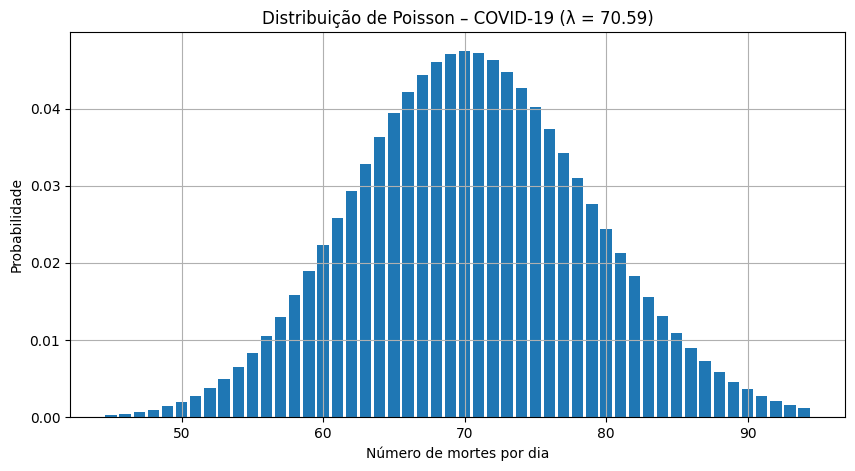

In [31]:
# Convertendo data
sim['DTOBITO_DATA'] = pd.to_datetime(sim['DTOBITO'], format='%d%m%Y', errors='coerce')

# Filtrando para COVID (corretamente)
filtro_covid = sim['CAUSABAS'].isin(['B342'])

# Agrupando por data
mortes_por_dia = sim[filtro_covid].groupby(sim['DTOBITO_DATA'].dt.date).size()

# λ = média diária
lambda_covid = mortes_por_dia.mean()
print(f"Média diária (λ) = {lambda_covid:.2f}")

k = 60  # por exemplo
p = poisson.pmf(k, mu=lambda_covid)
print(f"P(X = {k} mortes) = {p:.4f} → {p:.2%}")

# Distribuição de Poisson
k_vals = range(int(lambda_covid - 3 * lambda_covid**0.5), int(lambda_covid + 3 * lambda_covid**0.5))
probs = poisson.pmf(k_vals, mu=lambda_covid)

#mortes_por_dia.plot(figsize=(14, 5), title='Óbitos por dia em 2021')

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(k_vals, probs)
plt.title(f'Distribuição de Poisson – COVID-19 (λ = {lambda_covid:.2f})')
plt.xlabel('Número de mortes por dia')
plt.ylabel('Probabilidade')
plt.grid(True)
plt.show()